In [1]:
from sea_breeze import load_model_data, sea_breeze_funcs, sea_breeze_filters
from dask.distributed import Client
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

In [2]:
client = Client()
client

2025-01-15 14:10:18,090 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-01-15 14:10:18,095 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-01-15 14:10:18,100 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43189 instead
  warnings.warn(


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0017.gadi.nci.org.au/19310/proxy/43189/status,
Dashboard: /node/gadi-cpu-bdw-0017.gadi.nci.org.au/19310/proxy/43189/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42735,Workers: 7
Dashboard: /node/gadi-cpu-bdw-0017.gadi.nci.org.au/19310/proxy/43189/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46243,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0017.gadi.nci.org.au/19310/proxy/45157/status,Memory: 0 B
Nanny: tcp://127.0.0.1:38029,


## First define the spatial and temporal bounds for the detection

In [3]:
t1 = "2016-01-11 12:00"
t2 = "2016-01-12 12:00"
lat_slice = slice(-12.5,-10.5)
lon_slice = slice(129.5,132)
hgt_slice = slice(0,5000)

## Load model data

* Here we are loading data from AUS2200 (https://dx.doi.org/10.25914/w95d-q328)
* First load the land sea mask, which is used to compute the angle of the coastline and onshore wind component
* Then, u (model levels), v (model levels), uas, vas, hus, and tas

In [4]:
#Load land sea mask and compute coastline angles
orog, lsm = load_model_data.load_aus2200_static(
    "mjo-elnino",
    lon_slice,
    lat_slice)
angle_ds = load_model_data.get_coastline_angle_kernel(
    lsm,
    R=4,
    compute=True)

INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...
INFO: Calculating the sum of the weights...
INFO: Calculating variance...
INFO: Calculating minimum distance to the coast...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in power
 

Text(0.5, 1.0, 'Orientation angle of dominant coastline\nHatching: Where angle variance is large\n(competing coastline orientations)')

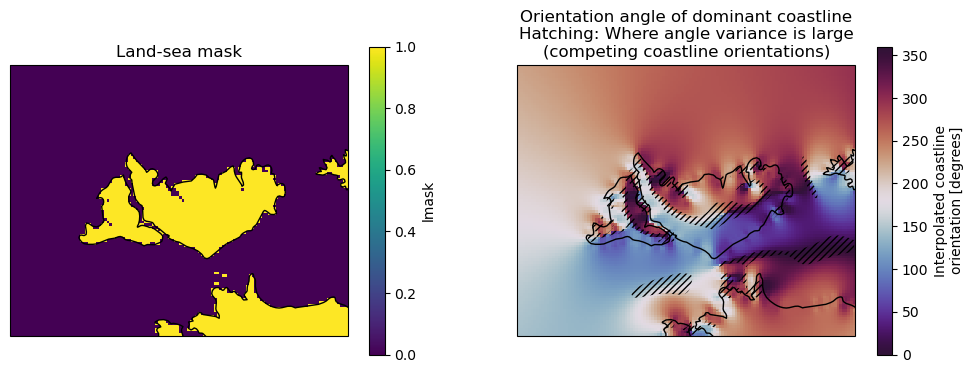

In [6]:
plt.figure(figsize=[12,4])
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
lsm.plot()
ax.coastlines()
plt.title("Land-sea mask")
ax = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
angle_ds.angle_interp.plot(cmap="twilight_shifted",vmin=0,vmax=360)
xr.plot.contourf(angle_ds.variance_interp,levels=[0.,0.5],hatches=["","/////"],colors="none",add_colorbar=False)
ax.coastlines()
plt.title("Orientation angle of dominant coastline\nHatching: Where angle variance is large\n(competing coastline orientations)")

In [7]:
chunks = {"lev":{},"time":1,"lat":-1,"lon":-1}
aus2200_va = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "va",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lat",
        hgt_slice=hgt_slice),
          "1hr")
aus2200_ua = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "ua",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "1hr",
        chunks=chunks,
        staggered="lon",
        hgt_slice=hgt_slice),
          "1hr")
aus2200_vas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "vas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lat"),
          "10min")
aus2200_uas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "uas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lon"),
          "10min")
aus2200_hus = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "hus",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks),
          "10min")
aus2200_tas = load_model_data.round_times(
        load_model_data.load_aus2200_variable(
            "tas",
            t1,
            t2,
            "mjo-elnino",
            lon_slice,
            lat_slice,
            "10min",
            chunks=chunks),
            "10min")   
aus2200_zmla = load_model_data.round_times(
        load_model_data.load_aus2200_variable(
            "zmla",
            t1,
            t2,
            "mjo-elnino",
            lon_slice,
            lat_slice,
            "1hr",
            chunks=chunks,
            staggered="time"),
              "1hr")

## Sea breeze functions

Compute three diagnostics of sea breezes
* Sea breeze (circulation) index (Hallgren et al. 2023)
* 2d kinematic moisture frontogenesis relative to the coastline
* Fuzzy algorithm based on time rate of change (Coceal et al. 2018)

In [8]:
#Sea breeze index
aus2200_wind = xr.Dataset({"u":aus2200_ua,"v":aus2200_va})
sbi = sea_breeze_funcs.calc_sbi(aus2200_wind,
                            angle_ds.angle_interp,
                            subtract_mean=False,
                            height_method="blh",
                            blh_da=aus2200_zmla,
                            height_mean=False,
                            vert_coord="lev")

In [9]:
#Moisture frontogenesis
Fc = sea_breeze_funcs.coast_relative_frontogenesis(
        aus2200_hus,
        aus2200_uas,
        aus2200_vas,
        angle_ds.angle_interp
    ) 

In [10]:
#Fuzzy algorithm
F_hourly = sea_breeze_funcs.hourly_change(
    aus2200_hus,
    aus2200_tas,
    aus2200_uas,
    aus2200_vas,
    angle_ds.angle_interp,
    lat_chunk="auto",
    lon_chunk="auto"
)    

F_fuzzy = field = sea_breeze_filters.fuzzy_function_combine(
    F_hourly.wind_change,
    F_hourly.q_change,
    F_hourly.t_change, combine_method="mean")

### Plot each of the sea breeze functions for a single time step

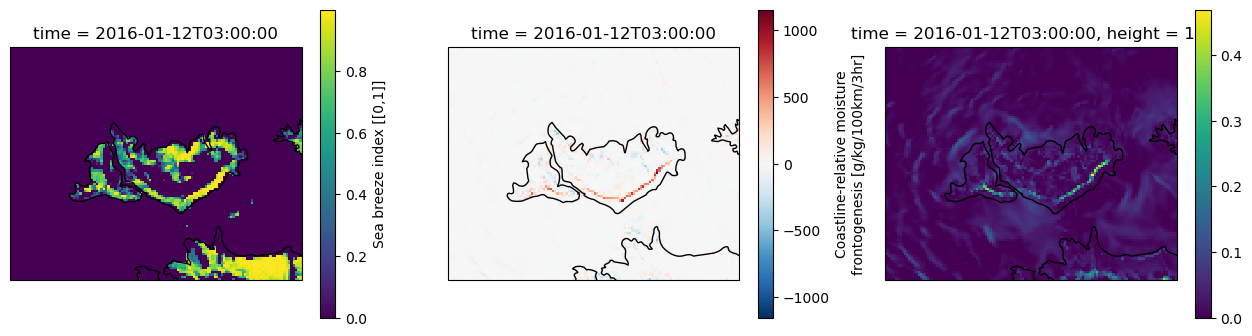

In [13]:
t = "2016-01-12 03:00"

plt.figure(figsize=[16,4])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
sbi.sel(time=t).sbi.plot()
ax.coastlines()

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
Fc.sel(time=t).Fc.plot()
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
F_fuzzy.sel(time=t).plot()
ax.coastlines()

## Sea breeze filters

* Now identify sea breeze objects in each of the functions
* Each function is transformed into a binary mask using the 97.5th percentile value as a threshold over the entire spatial-temporal domain (between t1 and t2)
* Several conditions can be applied to filter out non sea breeze objects

Re-shaping field for percentile calculation...
Using threshold:  [0.85140491]
Re-shaping field for percentile calculation...
Using threshold:  [102.97622695]
Re-shaping field for percentile calculation...
Using threshold:  [0.15208095]


Text(0.5, 1.0, 'Sea breeze objects from fuzzy\ndetection algorithm')

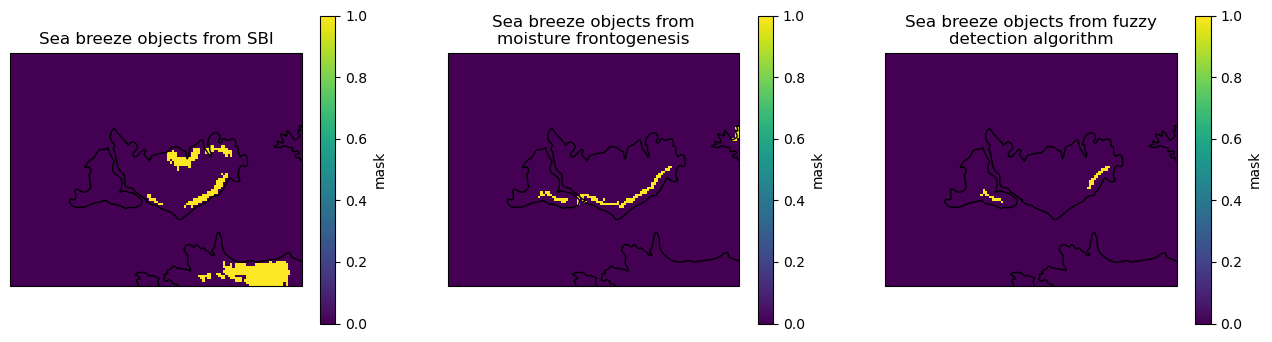

In [17]:
plt.figure(figsize=[16,4])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
sea_breeze_filters.filter_ds_driver(
    sbi.sbi,
    area_thresh=50,
    hour_min_lst=10,
    hour_max_lst=22,
    aspect_filter=True,
    aspect_thresh=2,
    p=97.5
).mask.sel(time=t).plot()
ax.coastlines()
plt.title("Sea breeze objects from SBI")

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
sea_breeze_filters.filter_ds_driver(
    Fc.Fc,
    area_thresh=50,
    hour_min_lst=10,
    hour_max_lst=22,
    p=97.5
).mask.sel(time=t).plot()
ax.coastlines()
plt.title("Sea breeze objects from\nmoisture frontogenesis")

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
sea_breeze_filters.filter_ds_driver(
    F_fuzzy,
    area_thresh=50,
    hour_min_lst=10,
    hour_max_lst=22,
    p=97.5
).mask.sel(time=t).plot()
ax.coastlines()
plt.title("Sea breeze objects from fuzzy\ndetection algorithm")